In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd


class MultiAgentMicrogridEnv(gym.Env):

    def __init__(self, df, num_agents=5):
        super(MultiAgentMicrogridEnv, self).__init__()
        self.num_agents = num_agents

        unique_ids = df['Household_ID'].unique()[:num_agents]
        df = df[df['Household_ID'].isin(unique_ids)]

        self.temps = df.pivot(index='Date', columns='Household_ID', values='Avg_Temperature_C').fillna(20).values
        self.cons = df.pivot(index='Date', columns='Household_ID', values='Energy_Consumption_kWh').fillna(5).values

        self.total_step = len(df['Date'].unique())
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_obs()
    
    def _get_obs(self):
        t = self.temps[self.current_step] / 30.0
        c = self.cons[self.current_step] / 10

        return np.stack([t, c], axis=1)
    
    def step(self, actions):
        current_temps = self.temps[self.current_step]
        current_cons = self.cons[self.current_step]

        actual_load = current_cons * (1 - actions.flatten())
        total_energy_cons = np.sum(actual_load, axis=0)
        
        price = 0.1 + 0.5 * total_energy_cons

        rewards = []
        for agent in range(self.num_agents):
            cost = actual_load[agent] * price
            discomfort = (current_cons[agent] * (actions[agent] ** 2)) * (current_temps[agent] / 30.0)
            reward = -(cost + discomfort)

            rewards.append(reward)

        self.current_step += 1
        done = self.current_step >= (self.total_step)

        next_obs = self._get_obs() if not done else np.zeros((self.num_agents, 2))

        return next_obs, np.array(rewards), done, {}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class ActorCriticNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)

        self.actor_mu = nn.Linear(64, action_dim) 
        self.actor_sig = nn.Linear(64, action_dim) 

        self.critic = nn.Linear(64, 1) 

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        actor_mu = torch.sigmoid(self.actor_mu(x))
        actor_sig = (torch.sigmoid(self.actor_sig(x)) * 0.3) + 0.01

        critic = self.critic(x)

        return actor_mu, actor_sig, critic

    def evaluate(self, state, action):
        
        mu, sig, state_value = self.forward(state)
        dist = Normal(mu, sig)
        actions_log_normal = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return actions_log_normal, state_value, dist_entropy

In [3]:
import torch.optim as optim

class PPOAgent:
    def __init__(self, input_dim, action_dim, lr=0.002, gamma=0.99, K_epochs=4, eps_clip=0.2):
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.lr = lr
        self.gamma = gamma
        
        self.policy = ActorCriticNetwork(input_dim, action_dim)
        self.old_policy = ActorCriticNetwork(input_dim, action_dim)

        self.old_policy.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.buffer = []

    def store(self, state, action, log_prob, reward, done):
        obs = (state, action, log_prob, reward, done)
        self.buffer.append(obs)

    def update(self):

        states, actions, log_probs, rewards, done = zip(*self.buffer)
        discounted_rewards = []
        current_reward = 0
        
        for reward, is_terminal in zip(reversed(rewards), reversed(done)):
            if is_terminal:
                current_reward = 0
            
            current_reward = reward + (self.gamma * current_reward)
            discounted_rewards.insert(0, current_reward)
        
        discounted_rewards_t = torch.FloatTensor(discounted_rewards)
        discounted_rewards_t = (discounted_rewards_t - discounted_rewards_t.mean()) / (discounted_rewards_t.std() + 1e-6) 

        old_states = torch.stack(states).squeeze().detach()
        old_actions = torch.stack(actions).squeeze().detach()
        old_logprobs = torch.stack(log_probs).squeeze().detach()

        for _ in range(self.K_epochs):

            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            logprobs = logprobs.squeeze()
            ratio = torch.exp(logprobs - old_logprobs.detach())
            state_values = state_values.squeeze()
            advantage = discounted_rewards_t - state_values.detach()

            surr_1 = ratio * advantage
            surr_2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage

            loss = -torch.min(surr_1, surr_2) + 0.5 * F.mse_loss(state_values, discounted_rewards_t) - 0.01 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.old_policy.load_state_dict(self.policy.state_dict())
        self.buffer = []

Starting MARL PPO Training...
Episode 0 | Avg Team Reward: -439.10
Episode 10 | Avg Team Reward: -592.28
Episode 20 | Avg Team Reward: -694.02
Episode 30 | Avg Team Reward: -471.46
Episode 40 | Avg Team Reward: -399.16
Episode 50 | Avg Team Reward: -567.86
Episode 60 | Avg Team Reward: -457.52
Episode 70 | Avg Team Reward: -652.67
Episode 80 | Avg Team Reward: -485.27
Episode 90 | Avg Team Reward: -485.85
Episode 100 | Avg Team Reward: -397.49
Episode 110 | Avg Team Reward: -404.79
Episode 120 | Avg Team Reward: -382.11
Episode 130 | Avg Team Reward: -348.23
Episode 140 | Avg Team Reward: -469.03
Episode 150 | Avg Team Reward: -405.63
Episode 160 | Avg Team Reward: -367.41
Episode 170 | Avg Team Reward: -375.64
Episode 180 | Avg Team Reward: -332.23
Episode 190 | Avg Team Reward: -334.89
Episode 200 | Avg Team Reward: -283.07
Episode 210 | Avg Team Reward: -349.91
Episode 220 | Avg Team Reward: -465.32
Episode 230 | Avg Team Reward: -378.12
Episode 240 | Avg Team Reward: -344.47
Episod

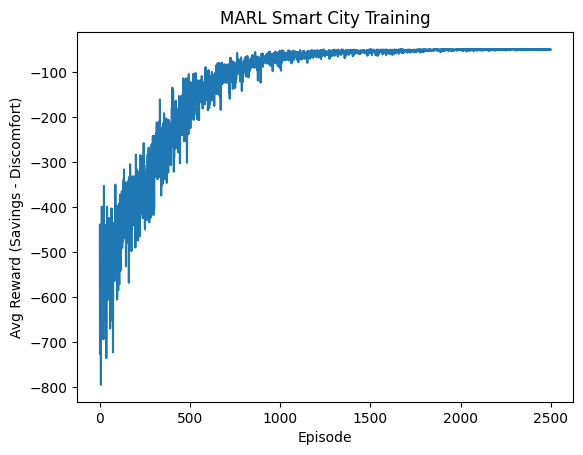

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('household_energy_consumption.csv')
num_agents = 5
env = MultiAgentMicrogridEnv(df, num_agents=num_agents)

ppo_agent = PPOAgent(input_dim=2, action_dim=1, lr=0.0001, gamma=0.99)

num_episodes = 2500
update_interval = 10

all_rewards = []

print("Starting MARL PPO Training...")

agent_memories = {i: [] for i in range(num_agents)}

for episode in range(num_episodes):
    obs = env.reset()
    episode_reward = 0
    done = False
    
    # 1. Run the Episode
    while not done:
        actions_list = []  
        step_data = []
        
        for i in range(num_agents):
            state = torch.FloatTensor(obs[i]).unsqueeze(0)
            
            with torch.no_grad():
                mu, sigma, _ = ppo_agent.old_policy(state)
                dist = torch.distributions.Normal(mu, sigma)
                action = dist.sample()
                action_clipped = torch.clamp(action, 0.0, 1.0)
                log_prob = dist.log_prob(action)
            
            actions_list.append(action_clipped.item())
            
            # Store data in a temp list (NOT the main memory yet)
            step_data.append({
                'state': state,
                'action': action,
                'log_prob': log_prob,
                'agent_id': i
            })
            
        actions_np = np.array(actions_list)
        next_obs, rewards, done, _ = env.step(actions_np)
        
        episode_reward += np.mean(rewards)
        
        # Store in the agent-specific history
        for i in range(num_agents):
            agent_memories[i].append(
                (step_data[i]['state'], 
                 step_data[i]['action'], 
                 step_data[i]['log_prob'], 
                 rewards[i], 
                 done)
            )
        
        obs = next_obs

    all_rewards.append(episode_reward)

    # 2. The UPDATE Step (Correctly Indented!)
    # Only run this if we hit the update interval
    if episode % update_interval == 0 and episode > 0:
        
        # A. Clear the old PPO buffer
        ppo_agent.buffer = []
        
        # B. Move fresh data from agent_memories to PPO buffer
        for i in range(num_agents):
            history = agent_memories[i]
            for step in history:
                ppo_agent.store(*step)
            # Clear agent memory after moving it
            agent_memories[i] = []
        
        # C. Update the Network
        ppo_agent.update()

    if episode % 10 == 0:
        print(f"Episode {episode} | Avg Team Reward: {episode_reward:.2f}")



plt.plot(all_rewards)
plt.title("MARL Smart City Training")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (Savings - Discomfort)")
plt.show()

Running Validation Loop for 6 steps...


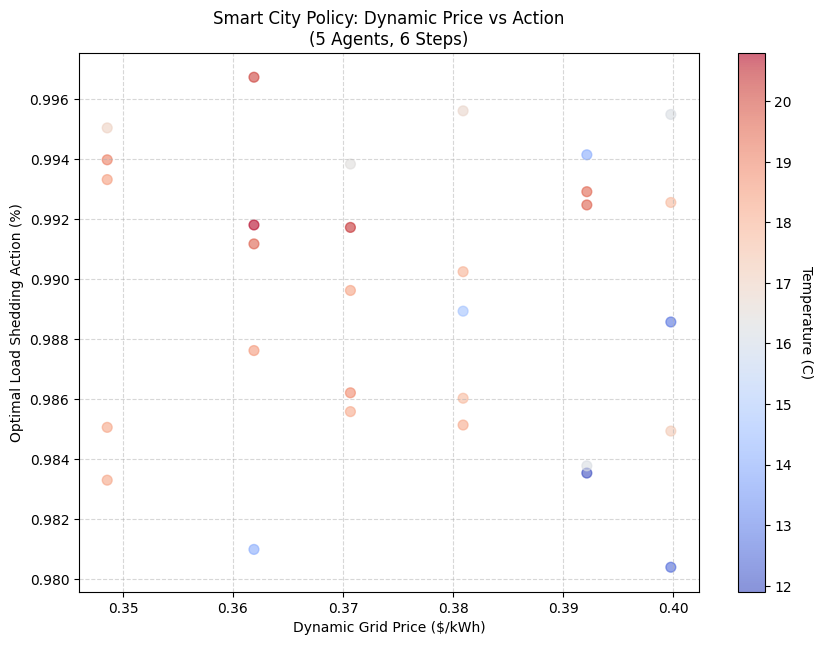

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# Set model to evaluation mode
ppo_agent.policy.eval()

# 1. Setup Test Data (Shortened for 7-day dataset)
episode_length = 6  # Fix: Reduced from 168 to 6 to fit data
# We start at step 0 or 1 to have enough room
start_step = 0 
num_agents = env.num_agents

# Lists to collect data for plotting
price_log = []
action_log = []
temp_log = []

print(f"Running Validation Loop for {episode_length} steps...")

# 2. Run Validation Loop
for i in range(episode_length):
    # Get current time step index
    current_idx = start_step + i
    
    # Extract raw data for ALL agents at this time step
    raw_temps = env.temps[current_idx]  # Shape: (5,)
    raw_cons = env.cons[current_idx]    # Shape: (5,)
    
    # Prepare states for the network (Normalize matches _get_obs logic)
    # State: [Temp/30, Cons/10]
    norm_temps = raw_temps / 30.0
    norm_cons = raw_cons / 10.0
    
    # Stack into a tensor: Shape (5, 2)
    states = torch.tensor(np.stack([norm_temps, norm_cons], axis=1), dtype=torch.float32)
    
    # Get Actions from the trained policy (No Gradients)
    with torch.no_grad():
        mu, _, _ = ppo_agent.policy(states)
        actions = mu.numpy().flatten() # Shape: (5,)
    
    # --- CALCULATE DYNAMIC PRICE ---
    actual_loads = raw_cons * (1 - actions)
    total_neighborhood_load = np.sum(actual_loads)
    dynamic_price = 0.1 + (0.5 * total_neighborhood_load)

    # Log Data for each agent
    for j in range(num_agents):
        price_log.append(dynamic_price) 
        action_log.append(actions[j])   
        temp_log.append(raw_temps[j])   

# 3. Generate Insightful Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(price_log, 
                      action_log, 
                      c=temp_log, 
                      cmap='coolwarm', 
                      alpha=0.6,
                      s=50)

cbar = plt.colorbar(scatter)
cbar.set_label('Temperature (C)', rotation=270, labelpad=15)

plt.xlabel("Dynamic Grid Price ($/kWh)")
plt.ylabel("Optimal Load Shedding Action (%)")
plt.title(f"Smart City Policy: Dynamic Price vs Action\n(5 Agents, {episode_length} Steps)")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()